In [1]:
from keras import models
from keras import layers
from keras.utils import to_categorical
import numpy as np

import os

Using TensorFlow backend.


In [2]:
import imageio

In [3]:
img_url = './Data/chest_xray/train/PNEUMONIA/person1491_bacteria_3893.jpeg'

In [4]:
img_url = './Data/chest_xray/train/NORMAL/IM-0115-0001.jpeg'

In [5]:
imageio.imread(img_url).shape

(1858, 2090)

In [6]:
img_url = './Data/chest_xray/train/NORMAL/IM-0117-0001.jpeg'
imageio.imread(img_url).shape

(1152, 1422)

Looks like the Chest Xray images are not Uniform size, let's create a function that reads through the Xrays and loads them in. 

Then we can take those loaded in XRays and read them in as 

In [7]:
import cv2

In [8]:
im = imageio.imread(img_url)
im2 = cv2.resize(im,(200,200))

In [9]:
%matplotlib inline

In [10]:
import matplotlib.pyplot as plt

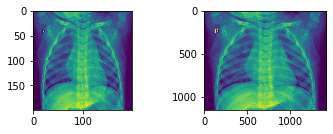

In [11]:
plt.subplot(221)
plt.imshow(im2)
plt.subplot(222)
plt.imshow(im)
plt.show()


Much better, it's the same image, but now we can structure it to a standard size which will be needed for modeling


Let's load all the images and their classification so we can build our Network

The file Structure for our images look like this:

Data/chest_xray/train/NORMAL for Non-pneumonia Xrays 

and

Data/chest_xray/train/PNEUMONIA for pneumonia Xrays

In [12]:
pathp =  'Data/chest_xray/train/PNEUMONIA'
pathn = 'Data/chest_xray/train/NORMAL'
pathp_test =  'Data/chest_xray/test/PNEUMONIA'
pathn_test = 'Data/chest_xray/test/NORMAL'

In [13]:
def acquire_images(path, size=(200,200)):
    if not path.endswith('/'):
        path += '/'
    
    files = os.listdir(path)
    return [np.asarray(cv2.resize(cv2.imread(path+file),size)) for file in files if file.endswith('.jpeg')]
    

In [14]:
def merge_two_image_sets(path_p, path_n):
    pneumonia = acquire_images(path_p)
    nomonia = acquire_images(path_n)
    p_y = [1 for im in pneumonia]
    n_y = [0 for im in nomonia]
    
    return(np.asarray(pneumonia + nomonia), p_y + n_y)

In [15]:
X_train,y_train = merge_two_image_sets(pathp,pathn)

In [16]:
X_test,y_test = merge_two_image_sets(pathp_test,pathn_test)

In [17]:


from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)


In [18]:
from keras.models import Sequential
from keras.layers import Dense , Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD , RMSprop
from keras.layers import Conv2D , BatchNormalization
from keras.layers import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint

In [19]:
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1)
filepath="weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


/home/snorks/dev/ml/img_class/pneumonia/venv/lib/python3.7/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [20]:
X_train.shape

(5216, 200, 200, 3)

In [21]:
X_test.shape

(624, 200, 200, 3)

In [22]:
X_train = X_train.reshape(5216,3,200,200)
X_test = X_test.reshape(624,3,200,200)

In [23]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=(3,200,200)))
model.add(Conv2D(16, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(64, (3, 3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(64, activation=K.sigmoid))
model.add(Dropout(0.4))
model.add(Dense(2 , activation='sigmoid'))

model.compile(loss='binary_crossentropy',
                  optimizer=RMSprop(lr=0.00005),
                  metrics=['accuracy'])

print(model.summary())



W0620 08:49:40.977422 140072613860992 deprecation_wrapper.py:119] From /home/snorks/dev/ml/img_class/pneumonia/venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0620 08:49:41.010199 140072613860992 deprecation_wrapper.py:119] From /home/snorks/dev/ml/img_class/pneumonia/venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0620 08:49:41.013979 140072613860992 deprecation_wrapper.py:119] From /home/snorks/dev/ml/img_class/pneumonia/venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0620 08:49:41.026364 140072613860992 deprecation_wrapper.py:119] From /home/snorks/dev/ml/img_class/pneumonia/venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:17

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 200, 200)      448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 200, 200)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 100, 100)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 100, 100)      4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 100, 100)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 50, 50)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 50, 50)        18496     
__________

In [24]:
batch_size = 256
epochs = 6

In [25]:
history = model.fit(X_train, y_train, validation_data = (X_test , y_test) ,callbacks=[lr_reduce,checkpoint] ,
          epochs=epochs)

Train on 5216 samples, validate on 624 samples
Epoch 1/6
5216/5216 [==============================] - 233s 45ms/step - loss: 0.4552 - acc: 0.8066 - val_loss: 0.4769 - val_acc: 0.7853

Epoch 00001: val_acc improved from -inf to 0.78526, saving model to weights.hdf5
Epoch 2/6
5216/5216 [==============================] - 227s 44ms/step - loss: 0.3018 - acc: 0.9030 - val_loss: 0.6507 - val_acc: 0.6955

Epoch 00002: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 00002: val_acc did not improve from 0.78526
Epoch 3/6
5216/5216 [==============================] - 224s 43ms/step - loss: 0.2385 - acc: 0.9363 - val_loss: 0.5509 - val_acc: 0.7436

Epoch 00003: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-07.

Epoch 00003: val_acc did not improve from 0.78526
Epoch 4/6
5216/5216 [==============================] - 227s 44ms/step - loss: 0.2287 - acc: 0.9405 - val_loss: 0.5344 - val_acc: 0.7476

Epoch 00004: ReduceLROnPlateau reducing learning rate to 4.999